In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.feature_extraction.text import TfidfVectorizer
from stemming.porter2 import stem
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

## Load the dataset

In [2]:
df = pd.read_json('../Datasets/Sms_spam_1.json').sort_index()

## Explore the dataset

In [3]:
df.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.shape

(5574, 2)

In [5]:
df['label'].unique()

array([0, 1])

In [6]:
df['label'].value_counts(normalize=True)

0    0.865985
1    0.134015
Name: label, dtype: float64

## Select the features

In [7]:
x = df['message']
y = df['label']

In [8]:
x.shape

(5574,)

## Split into train and test sets

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)

## Define a stemming tokenizer

In [10]:
def tokenizer_porter(doc):
  return [stem(word) for word in doc.split()]

## Vectorize the messages

In [11]:
vectorizer = TfidfVectorizer(stop_words='english', tokenizer = tokenizer_porter)

In [12]:
x = vectorizer.fit_transform(df['message']).toarray()

In [13]:
x_train = vectorizer.fit_transform(x_train).toarray()
x_test = vectorizer.transform(x_test).toarray()

## Scale the features

In [14]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Dimensionality Reduction with PCA

In [15]:
pca = PCA(n_components=150)
x_train_r = pca.fit_transform(x_train)
x_test_r = pca.transform(x_test)

In [16]:
np.cumsum(pca.explained_variance_ratio_)

array([ 0.00233098,  0.00457342,  0.0067942 ,  0.00865516,  0.0104289 ,
        0.01216456,  0.01382374,  0.01547437,  0.01712087,  0.01873993,
        0.02031125,  0.02185604,  0.02339195,  0.02490779,  0.02641511,
        0.02791314,  0.02940482,  0.03086497,  0.03232232,  0.03374306,
        0.03515951,  0.03654611,  0.03792897,  0.03931036,  0.04066694,
        0.04202102,  0.04336663,  0.04470512,  0.04603102,  0.0473412 ,
        0.04864836,  0.04993777,  0.05120654,  0.05245991,  0.05371224,
        0.05496164,  0.05620977,  0.0574531 ,  0.05868389,  0.05990973,
        0.06113155,  0.06234721,  0.06355805,  0.06475959,  0.06595164,
        0.0671413 ,  0.06832816,  0.06951164,  0.07068746,  0.07186049,
        0.07303165,  0.07419432,  0.07535364,  0.07649835,  0.07764206,
        0.07878452,  0.07992588,  0.08106447,  0.08220108,  0.08333506,
        0.08446213,  0.08558814,  0.08670467,  0.087817  ,  0.08892648,
        0.09003347,  0.09113873,  0.09223655,  0.09333237,  0.09

## Hyperparameter optimization with cross-validation

In [17]:
estimator =  RandomForestClassifier(n_estimators=100)

parameters ={'max_depth': np.arange(1,21)}

grid_search = GridSearchCV(estimator, parameters, cv =5, n_jobs=-1)
grid_search.fit(x_train_r, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [18]:
grid_search.best_score_

0.97536154258168184

In [19]:
grid_search.best_params_

{'max_depth': 16}

## Make predictions using the best model

In [20]:
model = grid_search.best_estimator_ #best model

In [21]:
y_pred = model.predict(x_test_r)

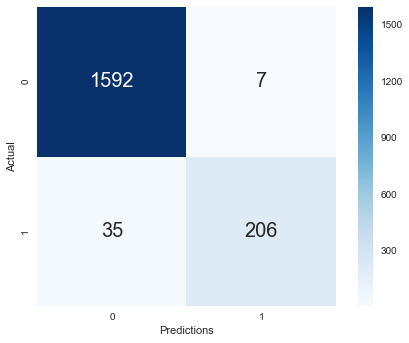

In [22]:
table = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predictions'])

sbn.heatmap(table, cbar=True, cmap='Blues',annot=True, square=True, fmt='d', annot_kws={'size': 20})
plt.show()

## Evaluate the best model

In [23]:
model.score(x_test_r,y_test) #Accuracy

0.97717391304347823

In [24]:
f1_score(y_test,y_pred)

0.90748898678414103